In [2]:
import pickle
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from scipy import stats
import os 
from copy import deepcopy
import re
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
import pyLDAvis
# from gensim.models import CoherenceModel
# import pyLDAvis.gensim_models as vis_gensim
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS, WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF 
from itertools import combinations
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/timo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/timo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/timo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Topic Modeling
Analysis of particpant's self report of learned rules. I look for common themes within each task/domain

In [3]:
# set a few parameters 
working_dir = os.getcwd()
data_dir = working_dir + '/data/'
domains = ['animals','vehicles']
curricula = ['blocked','interleaved']
rules = ['resp_ruleSpeed','resp_ruleSize']

# load data 
with open('animals_vehicles_pilot.pkl','rb') as f:
    alldata = pickle.load(f)

In [4]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def remove_stopwords(string,stopwords):
    '''
    removes stopwords from string
    '''
    # tokenise
    string = word_tokenize(string)
    # only keep non stopwords
    string = ' '.join([w for w in string if not w in stopwords])
    return string


def lemmatise(string):
    '''
    lemmatises words in sentence
    '''
    # tokenise the sentence
    string = word_tokenize(string)
    # lemmatise each word in sentence
    lemmatiser = WordNetLemmatizer()
    string = [lemmatiser.lemmatize(w,pos='n') for w in string]
    string = [lemmatiser.lemmatize(w,pos='v') for w in string]
    string = [lemmatiser.lemmatize(w,pos='a') for w in string]
    string = ' '.join(string)
    return string


def cleanup_txtresponses(alldata,whichstopwords='topicmodel'):
    domains = ['animals','vehicles']
    curricula = ['blocked','interleaved']
    rules = ['resp_ruleSpeed','resp_ruleSize']
    alldata2 = deepcopy(alldata)
    # stopwords: some standard stopwords of english language
    # sws = set(stopwords.words('english'))
    sws = set(STOPWORDS)
    # stopwords: task specific stopwords
    if whichstopwords=='wordcloud':
        sws.update(['animal','vehicle','orange','blue','store','think','reward','rule','accept','reject','remember','point',':','&',',','.','!','?','/','-','(',')',"n't",'=',"'","'m","'s",'+','wa'])
    elif whichstopwords=='topicmodel':
        sws.update([':','&',',','.','!','?','/','-','(',')',"n't",'=',"'","'m","'s",'+','wa'])

    for dom in domains:
        for cur in curricula:
            for rule in rules:
                for idx,string in enumerate(alldata[dom][cur][rule]):
                    # remove leading/trialing white space, remove newline escape char, all lower case
                    string =  string.strip().replace('\n',' ').lower()
                    string = string.replace('/',' ')
                    # lemmatisation
                    string = lemmatise(string)
                    # remove stopwords
                    string = remove_stopwords(string,sws)
                    # tokenisation
                    string = word_tokenize(string)
                    # remove leading hyphen
                    string = [re.sub('^-','',w) for w in string]
                    # remove trailing hyphen
                    string = [re.sub('-$','',w) for w in string]
                    # remove sequence of fullstops (of any length)
                    string = [re.sub('([.])*','',w) for w in string]
                    # remove empty strings
                    while "" in string:
                        string.remove("")
                    # store cleaned string in list
                    alldata2[dom][cur][rule][idx] = string
                    
    return alldata2



# a few helper functions

def make_dict_and_corpus(txt):
    '''
    generates dictionary, bag of words and word occurence matrix
    input: document with tokenised texts (list of lists)
    '''
    dictionary = gensim.corpora.Dictionary(txt)
    bow_corpus = [dictionary.doc2bow(doc,allow_update=True) for doc in txt]
    id_words = [[(dictionary[id],count) for id,count in line] for line in bow_corpus]
    return dictionary, bow_corpus, id_words


def compute_perplexity(lda_model,corpus):
    return lda_model.log_perplexity(corpus)

def compute_coherence_score(model,txt,dictionary):
    '''
    calculates coherence score.
    score > 0.5 acceptable
    score > 0.7 good
    '''
    coherence_model = CoherenceModel(model=model,texts=txt,dictionary=dictionary,coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence



def compute_acc_per_topic(data,topics,rule_id):
    # compute accuracy per subject:
    testtrials = data['expt_session']==2
    task_trials = data['expt_context']==(rule_id+1)
    accs=[]    
    for ii in range(testtrials.shape[0]):
        accs.append(np.nanmean(data['resp_correct'][ii,testtrials[ii,:]&task_trials[ii,:]]))
    # allocate accs to topics
    accs = np.asarray(accs)
    # sub_ids = np.arange(0,len(accs))
    accs_per_topic = []
    for top_id in np.sort(np.unique(topics)):
        # print(top_id)
        accs_per_topic.append(accs[topics==top_id])
    return accs_per_topic

def disp_acc_per_topic(alldata,inferred_topics):
    '''
    subplots: histogram of topics, accuracy per topic
    
    '''
    sem = lambda x: np.std(x,ddof=1) / np.sqrt(np.size(x))
    for dom in domains:
        for cur in curricula:
            for idx,rule in enumerate(rules):
                # print('## '+ dom + ' - ' + cur + ': ' + rule + ':')
                f,ax = plt.subplots(1,2,figsize=(8,5))
                ax = ax.ravel()
                # histogram of topics
                ax[0].hist(inferred_topics[dom][cur][rule]['dominant_topics'])
                ax[0].set(xlabel='Topic ID',ylabel='number of participants',title='distribution of topics')#,xticks=np.arange(0,4),xticklabels=np.arange(1,5))
                acc_per_topic = compute_acc_per_topic(alldata[dom][cur],inferred_topics[dom][cur][rule]['dominant_topics'],idx)
                for ii,accs in enumerate(acc_per_topic):
                    if len(accs) > 1:
                        ax[1].bar(ii,np.mean(accs),yerr=sem(accs),color='lightgreen')
                    else:
                        ax[1].bar(ii,np.mean(accs),color='lightgreen')
                    ax[1].set(xlabel='Topic ID',ylabel='avg accuracy',title='accuracy per topic')#,xticks=np.arange(0,4),xticklabels=np.arange(1,5))
                plt.suptitle(dom + ' - ' + cur + ': ' + rule,fontweight='bold' )
                plt.tight_layout()


def disp_topics(inferred_topics):
    '''
    prints most representative example sentences for each topic
    '''
    for dom in domains:
        for cur in curricula:
            for idx,rule in enumerate(rules):
                print('## '+ dom + ' - ' + cur + ': ' + rule + ':')                
                # show sentences
                for ii,sentences in enumerate(inferred_topics[dom][cur][rule]['top_sentences']):
                    print('### Topic ' + str(ii) + ':')
                    for sentence in sentences:
                        print('- ' + sentence.replace('\n','. '))
                print('\n')

def get_dominant_topics(bow_corpus,lda_model):
    df = pd.DataFrame()
    # get the topic weights for each sentence in the document
    for weights_per_sentence in lda_model[bow_corpus]:
        # sort them by the weight
        weights_per_sentence = sorted(weights_per_sentence,key=lambda x: (x[1]),reverse=True)
        # get dominant topic:
        topic_id = weights_per_sentence[0][0]
        topic_weight = weights_per_sentence[0][1]
        dominant_topic = lda_model.show_topic(topic_id)
        # extract keywords, drop their probabilities
        topic_keywords = ", ".join([w for w, p in dominant_topic])
        df = df.append(pd.Series([topic_id,round(topic_weight,3),topic_keywords]),ignore_index=True)
    # add original (unprocessed) text
    txt = pd.Series(txt_orig)
    df = pd.concat([df,txt],axis=1)
    # add domain and rule identifiers
    doms = pd.Series(domain_ids)
    rules = pd.Series(rule_ids)
    df = pd.concat([df,doms,rules],axis=1)
    df.columns = ['Dominant Topic (ID)', 'Topic Weight', 'Key Words', 'Report','Domain','Rule']
    df.reset_index()
    return df

    

## Preprocessing
preprocessing pipeline for NLP

In [5]:
with open('animals_vehicles_pilot.pkl','rb') as f:
    alldata = pickle.load(f)
    
# clean up text responses 
alldata_wc = cleanup_txtresponses(alldata,whichstopwords='wordcloud')


## Word Cloud and Word Counts
Let's have a look at dominant terms for each task

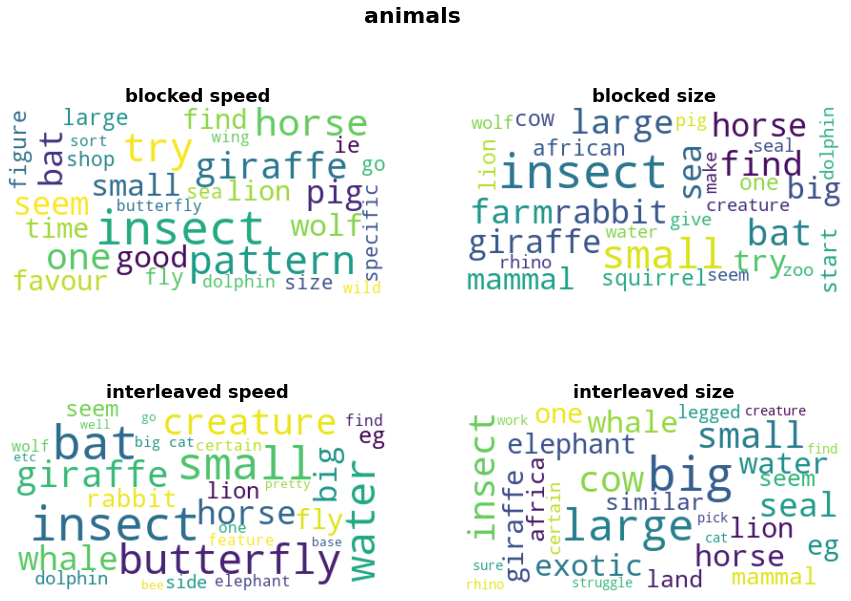

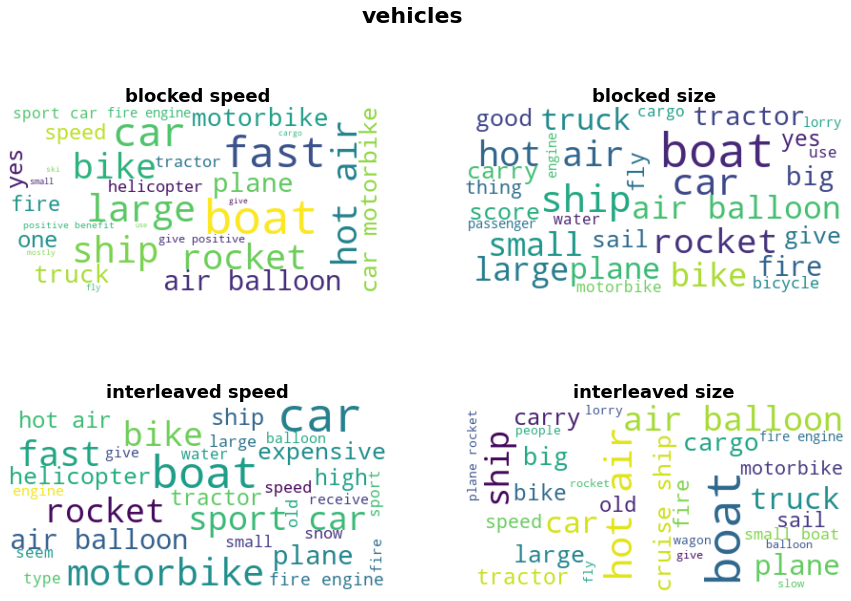

In [6]:

for dom in domains:
    f,ax = plt.subplots(2,2,figsize=(15,10))
    for x,cur in enumerate(curricula):
        for y,rule in enumerate(rules):
            txt = alldata_wc[dom][cur][rule]
            wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white").generate(''.join([' '.join(w) for w in txt]))
            # wordcloud = WordCloud().generate(''.join([' '.join(w) for w in txt]))
            ax[x,y].imshow(wordcloud,interpolation='bilinear')
            ax[x,y].axis('off')
            ax[x,y].set_title(cur + ' ' + rule.split('rule')[1].lower(),fontsize=18,fontweight='bold')
    plt.suptitle(dom,fontsize=22,fontweight='bold')

In [ ]:
# now let's look at the frequency with which terms occur in each task
for dom in domains:
    print(dom + '-----------')
    for cur in curricula:
        print(cur )
        for rule in ['resp_ruleSpeed','resp_ruleSize']:
            print(rule)
            txt_tokenised = alldata_wc[dom][cur][rule]
            txt_flat = [word for sentence in txt_tokenised for word in sentence]
            print(pd.Series(txt_flat).value_counts().sort_values(ascending=False)[:10])

# Topic Modeling with scikit-learn

I use non-negative matrix factorisation

## 1. Preprocessing

In [7]:
with open('animals_vehicles_pilot.pkl','rb') as f:
    alldata = pickle.load(f)
domains = ['animals','vehicles']
curricula = ['blocked','interleaved']
rules = ['resp_ruleSpeed','resp_ruleSize']
alldata_clean = deepcopy(alldata)
# stopwords: some standard stopwords of english language
# sws = set(stopwords.words('english'))
sws = set(STOPWORDS)
# stopwords: task specific stopwords
sws.update(['animal','vehicle','orange','blue','store',':','&',',','.','!','?','/','-','(',')',"n't",'=',"'","'m","'s",'+','wa'])
for dom in domains:
    for cur in curricula:
        for rule in rules:
            for idx,string in enumerate(alldata[dom][cur][rule]):
                # remove leading/trialing white space, remove newline escape char, all lower case
                string =  string.strip().replace('\n',' ').lower()
                string = string.replace('/',' ')
                # lemmatisation
                string = lemmatise(string)
                # remove stopwords
                string = remove_stopwords(string,sws)                
                # remove hyphens
                string = re.sub('-','',string)                
                # remove sequence of fullstops (of any length)
                string = re.sub('([.])*','',string)
                
                # store cleaned string in list
                alldata_clean[dom][cur][rule][idx] = string
                


## 2. Word2Vec Model
The number of topics is a hyperparameter. To find the right number of topics, I calculate a semantic **coherence score**. The score quantifies how semantically similar the most representative words within a topic are. 
Calculating this score requires a model of the documents in which distance between words relates to semantic similarity. Hence, I first need to build a **word2vec model** of the entire set of documents.  
More specifically, I'm going to calculate the **TC-W2V coherence measure**.

In [8]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# tokenise the texts 
alldata_tkn = deepcopy(alldata_clean)
for dom in domains:
    for cur in curricula:
        for rule in rules:
            for idx,string in enumerate(alldata_tkn[dom][cur][rule]):
                alldata_tkn[dom][cur][rule][idx] = word_tokenize(string)               

            # bigram = gensim.models.Phrases(alldata_tkn[dom][cur][rule], min_count=4, threshold=1) # higher threshold fewer phrases.
            # bigram_mod = gensim.models.phrases.Phraser(bigram)
            # alldata_tkn[dom][cur][rule] = make_bigrams(alldata_tkn[dom][cur][rule])



In [9]:
w2v_models = {}
for dom in domains:
    w2v_models[dom] = {}
    for cur in curricula:
        w2v_models[dom][cur] = {}
        for rule in rules:      
            print('building word2vec model')      
            
            # train w2v with skipgram
            w2v_models[dom][cur][rule] = gensim.models.Word2Vec(alldata_tkn[dom][cur][rule], vector_size=500,workers=6,epochs=500,max_vocab_size=None,min_count=1)
            print('final model has {:d} terms in total'.format(len(list(w2v_models[dom][cur][rule].wv.index_to_key))))
    


building word2vec model
final model has 349 terms in total
building word2vec model
final model has 296 terms in total
building word2vec model
final model has 290 terms in total
building word2vec model
final model has 251 terms in total
building word2vec model
final model has 301 terms in total
building word2vec model
final model has 282 terms in total
building word2vec model
final model has 312 terms in total
building word2vec model
final model has 318 terms in total


              x         y         z
boat  -1.323580 -0.414381  0.592534
air   -1.527050 -0.206593  0.975982
car   -1.301453  0.355068 -0.418285
large -0.787256 -0.673442  0.202953
ship  -0.573771 -0.780580  2.175413


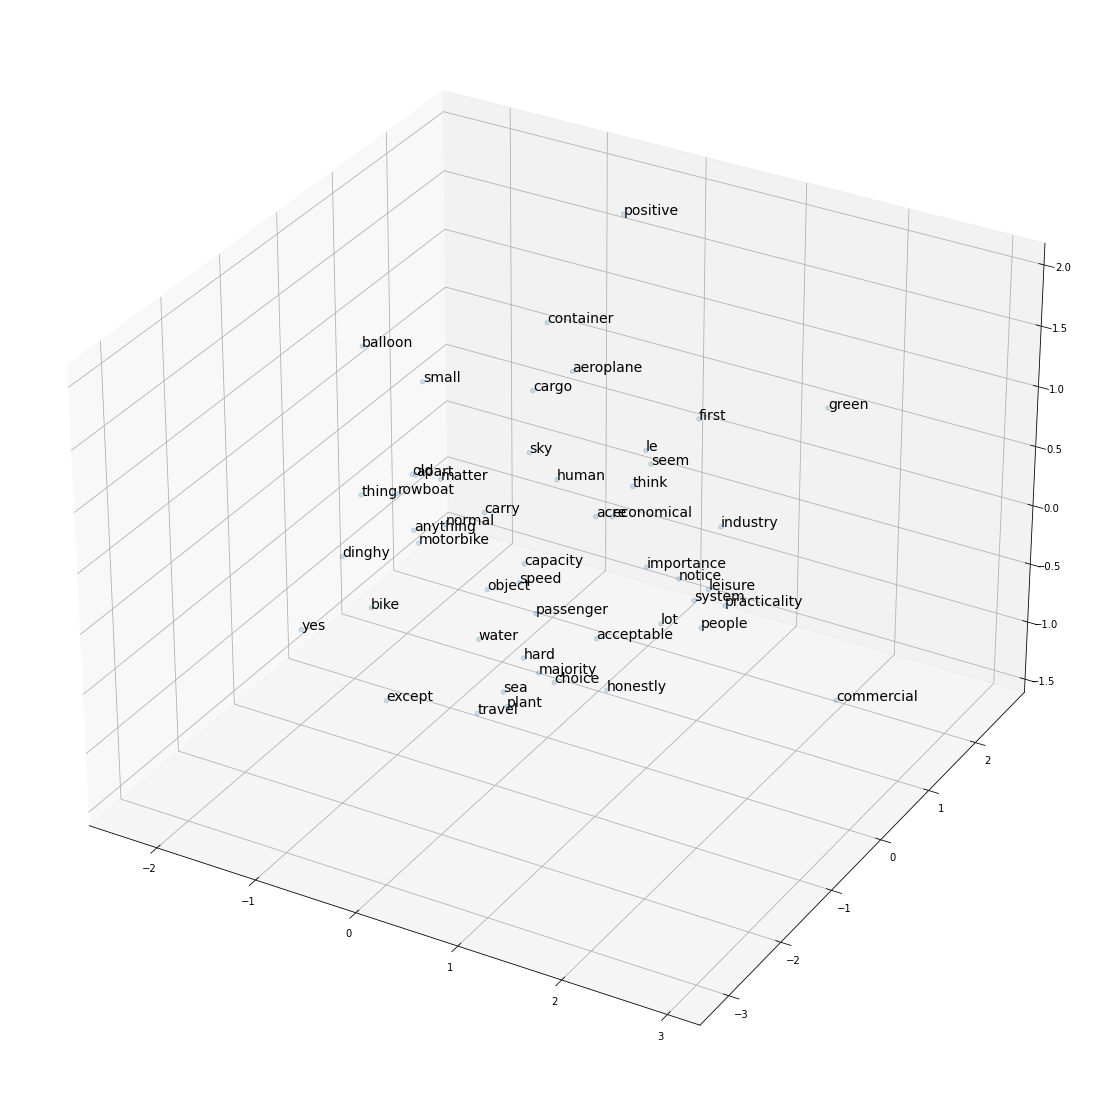

In [10]:
# word2vec visualisation with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3,whiten=True)
clf = pca.fit_transform(w2v_models['vehicles']['blocked']['resp_ruleSize'].wv[w2v_models['vehicles']['blocked']['resp_ruleSize'].wv.index_to_key])

data = pd.DataFrame(clf,index=w2v_models['vehicles']['blocked']['resp_ruleSize'].wv.index_to_key,columns=['x','y','z'])
print(data.head(5))

%matplotlib inline
# sample 50 words and display in 3d
data = data.sample(50)
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(111,projection='3d')
ax.scatter(data['x'],data['y'],data['z'],alpha=.2)
# add labels
for w,r in data.iterrows():
    x,y,z = r 
    ax.text(x,y,z,s=w,size=14,zorder=2,color='k')
plt.show()


## 3. Hyperparameter Grid search

In [9]:
# iterate over reports and perform NMF
max_df = 0.95 # maximum word freq to be included 
min_df = 2    # min word freq to be included 
max_features = 1000 # maximum number of unique words to include 
n_topics = np.arange(1,21,1)
%matplotlib qt
f,ax = plt.subplots(4,2,figsize=(20,15))
ax = ax.ravel()
plt_id = 0
coherences = dict()
for dom in domains:
    coherences[dom] = {}
    for cur in curricula:
        coherences[dom][cur] = {}
        for rule in rules:
            print(dom + '- ' + cur + '-' + rule.split('rule')[1].lower() + ':')
            coherences[dom][cur][rule] = []
            for itop,ntop in enumerate(n_topics):                
                tfidf = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features)
                # vectorisation
                data_tfidf = tfidf.fit_transform(alldata_clean[dom][cur][rule])
                

                # fit NMF model 
                nmf = NMF(n_components=ntop,alpha=.1,l1_ratio=0,init='nndsvd')
                nmf.fit(data_tfidf)
                # get document topic weights
                W = nmf.transform(data_tfidf)
                # get word topic weights
                H = nmf.components_
                
                # compute tc-w2v score
                # loop over topics
                ranked_words = []
                for idx,topic in enumerate(H):
                    topic_indices = topic.argsort()[-10::]
                    top_words = [tfidf.get_feature_names()[ii] for ii in topic_indices]
                    ranked_words.append(top_words)
                
                coherence = calculate_coherence(w2v_models[dom][cur][rule],ranked_words)
                # print("\t K={:d} topics; coherence={:.4f}".format(ntop,coherence))
                coherences[dom][cur][rule].append(coherence)
            ax[plt_id].plot(coherences[dom][cur][rule],linestyle='-.',color='r',markersize=5)
            ax[plt_id].set_title(dom + '- ' + cur + '-' + rule.split('rule')[1].lower() + ':')
            ax[plt_id].set_xlabel('number of topics')
            ax[plt_id].set_xticks(np.arange(len(n_topics)))
            ax[plt_id].set_xticklabels(n_topics )
            ax[plt_id].set_ylabel('tc-w2v score')
            plt_id += 1

plt.tight_layout()

animals- blocked-speed:
animals- blocked-size:
animals- interleaved-speed:
animals- interleaved-size:
vehicles- blocked-speed:
vehicles- blocked-size:
vehicles- interleaved-speed:
vehicles- interleaved-size:


## 4. Evaluation of best model

In [11]:
# iterate over reports and perform NMF on optimal number of topics
# optimal number of topics:
# n_optim = [7,9,6,7,6,3,4,3]
# n_optim = [12,12,12,12,6,3,4,3]
n_optim = [5]*8
ii = 0
max_df = 0.95 # maximum word freq to be included 
min_df = 2    # min word freq to be included 
max_features = 1000 # maximum number of unique words to include 

results = []
for dom in domains:
    for cur in curricula:
        for rule in rules:            
            tfidf = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features,ngram_range=(1,3))
            # vectorisation
            data_tfidf = tfidf.fit_transform(alldata_clean[dom][cur][rule])
           
            # fit NMF model 
            nmf = NMF(n_components=n_optim[ii],alpha=.1,l1_ratio=0,init='nndsvd')
            ii +=1
            nmf.fit(data_tfidf)
            # get document topic weights
            W = nmf.transform(data_tfidf)
            # get word topic weights
            H = nmf.components_
            results.append(([dom,cur,rule],nmf,W,H,tfidf))


In [12]:
# top 10 words
for grp,_,W,H,tfidf in results:
    print('\n' + '-'.join(grp))
    for idx,topic in enumerate(H):
        top10 = topic.argsort()[-10::]
        print('\t- top 10 words for topic {:02d}: \t'.format(idx+1) + ', '.join([tfidf.get_feature_names()[ii] for ii in top10]))
        


animals-blocked-resp_ruleSpeed
	- top 10 words for topic 01: 	caterpillar, giraffe, rodent, pig, reject, horse, accept, seal, reward, insect
	- top 10 words for topic 02: 	struggle, give point, figure, pattern, think, try remember, point, try, rule, remember
	- top 10 words for topic 03: 	favour, sure, think, exotic, one, consider, type, wing, large, small
	- top 10 words for topic 04: 	exception, thing, horse, understand, insect, mainly, think rule, rule, fly insect, fly
	- top 10 words for topic 05: 	rabbit, wolf horse, bat, seem, wolf, exotic, farm, big, big cat, cat

animals-blocked-resp_ruleSize
	- top 10 words for topic 01: 	well, small, bat, accept, mammal, zoo, insect rodent, sea, rodent, insect
	- top 10 words for topic 02: 	cow, horse, walrus, reject, base, small, one, good, big good, big
	- top 10 words for topic 03: 	live, assume, life, reward, aquatic, point, small, large mammal, mammal, large
	- top 10 words for topic 04: 	bat, find, one, horse, dolphin, cow, shop, think

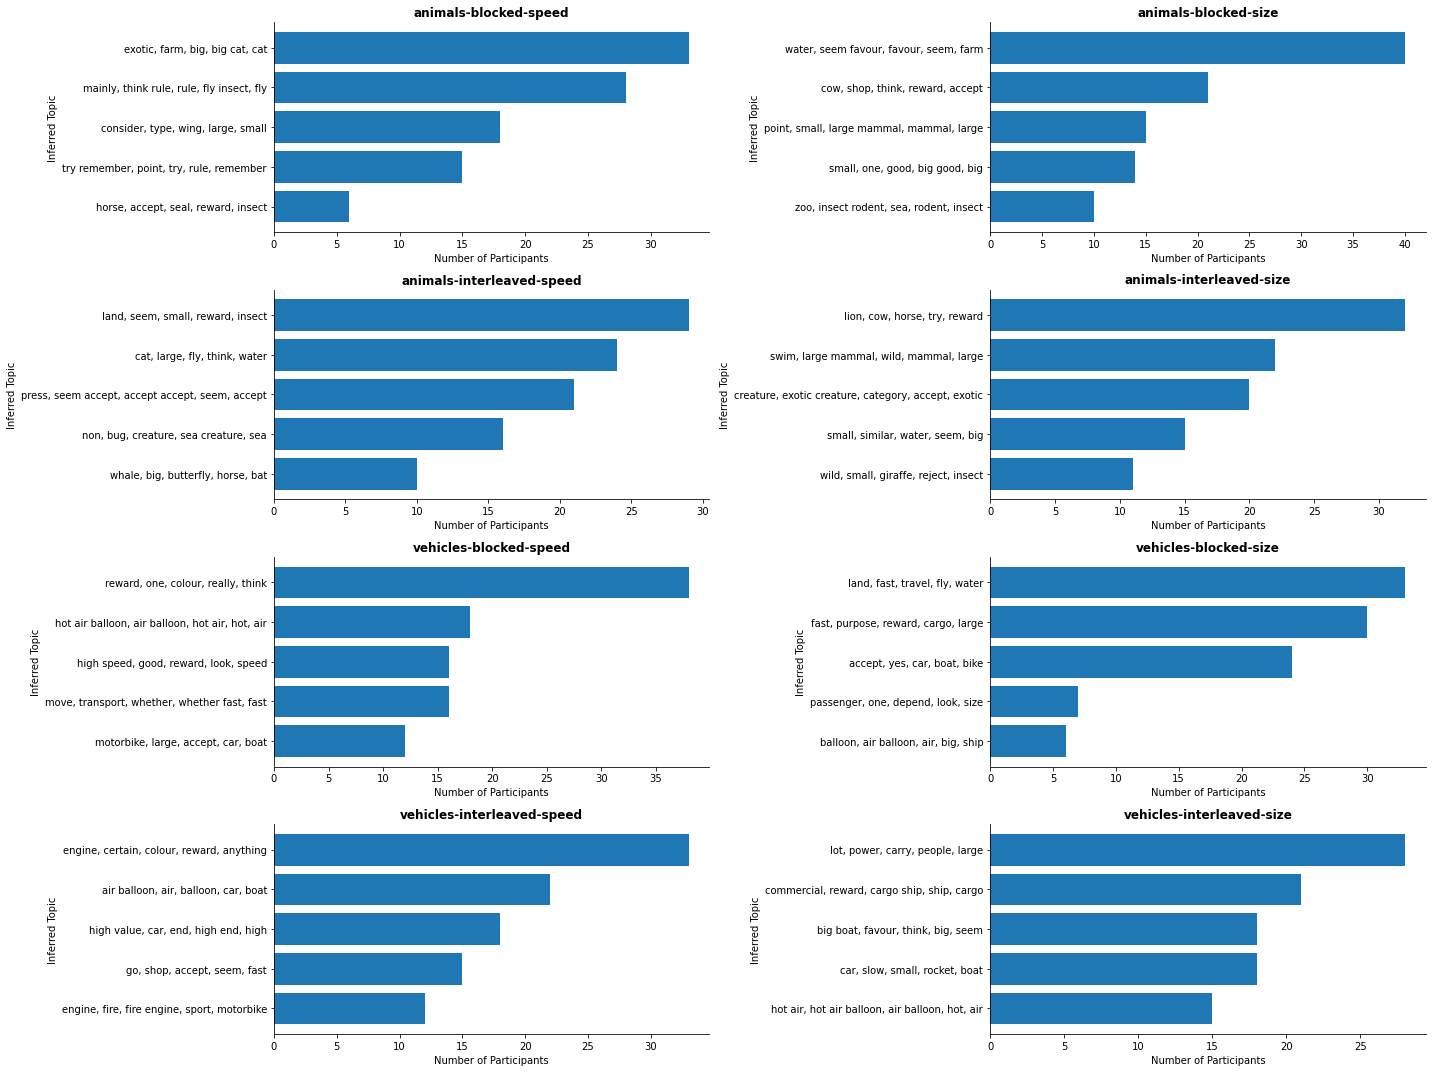

In [13]:
%matplotlib inline
# histogram of participants per rule
f,ax = plt.subplots(4,2,figsize=(20,15))
ax = ax.ravel()
for ii,r in zip(range(len(results)), results):
    grp,_,W,H,tfidf = r
    grp[-1] = grp[-1].split('rule')[-1].lower()
    grp_title = '-'.join(grp)
    # dominant topics per report
    topic_dist = np.argmax(W,axis=1)
    # number of participants per topic
    n_participants = np.histogram(topic_dist,bins=W.shape[1])[0]
    n_participants_sorted = n_participants.sort()
    # dominant keywords per topic 
    topicwords = []
    for idx,topic in enumerate(H):
        top10 = topic.argsort()[-5::]
        topicwords.append(', '.join([tfidf.get_feature_names()[ii] for ii in top10]))
    topicwords = [x for x, _ in sorted(zip(topicwords, n_participants), key=lambda pair: pair[1])]    
    ax[ii].barh(np.arange(len(topicwords)),n_participants)
    ax[ii].set_ylabel('Inferred Topic')
    ax[ii].set_xlabel('Number of Participants')
    ax[ii].set_title(grp_title,fontweight='bold')
    ax[ii].set_yticks(np.arange(len(topicwords)))
    ax[ii].set_yticklabels(topicwords)
    sns.despine()
plt.tight_layout()